In [1]:
! nvidia-smi

Fri May 17 16:03:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from torchvision.transforms import ToPILImage, Normalize, Compose
import PIL
import torch
from IPython.display import display

In [4]:
!git clone https://github.com/filippuo2000/GSN_ball_detection.git
%cd GSN_ball_detection

Cloning into 'GSN_ball_detection'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 147 (delta 77), reused 114 (delta 48), pack-reused 0
Receiving objects: 100% (147/147), 35.42 KiB | 5.06 MiB/s, done.
Resolving deltas: 100% (77/77), done.
/content/GSN_ball_detection


In [5]:
! gdown 1qbDJmxONPMs94Z24uv0YiWo2B_sRtLTP

Downloading...
From (original): https://drive.google.com/uc?id=1qbDJmxONPMs94Z24uv0YiWo2B_sRtLTP
From (redirected): https://drive.google.com/uc?id=1qbDJmxONPMs94Z24uv0YiWo2B_sRtLTP&confirm=t&uuid=d6f0e598-1436-4081-913a-a2bbd6066b21
To: /content/GSN_ball_detection/Dataset-small.zip
100% 221M/221M [00:01<00:00, 115MB/s]


In [12]:
!pip install -r requirements.txt

  Using cached pytorch_lightning-2.1.0-py3-none-any.whl (774 kB)
  Using cached wandb-0.17.0-py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.7 MB)
  Using cached torchmetrics-1.4.0.post0-py3-none-any.whl (868 kB)
  Using cached lightning_utilities-0.11.2-py3-none-any.whl (26 kB)
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl (9.0 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl (207 kB)
  Using cached sentry_sdk-2.2.0-py2.py3-none-any.whl (281 kB)
  Using cached setproctitle-1.3.3-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (30 kB)
  Using cached gitdb-4.0.11-py3-none-any.whl (62 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudn

In [7]:
%%shell
mkdir Dataset-small
unzip -q Dataset-small.zip -d Dataset-small

Poniżej zaprezentowano możliwość stworzenia nowego podziału danych na dane treningowe, walidacyjne oraz testowe.
Nazwa pliku, do którego została celowo zmieniona. Aby został on odczytany należy podział zapisać do pliku 'split.txt'

In [36]:
from InitializeDataset import InitializeDataset

Initialize_ds = InitializeDataset('Dataset-small')
Initialize_ds.initialize_data()
Initialize_ds.random_split((1000, 300)) #zostanie utworzony zbiór testowy wielkosci 1000, validacyjny 300, oraz testowy z pozostalych danych
Initialize_ds.stats()
Initialize_ds.write_split('example_split.txt')

Number of data:	1888
Number of train data:	1000
Number of validate data:	300
Number of test data:	588


Poniżej zaprezentowano proces inicjalizacji wag, ręczne wyświetlanie obrazów z wykorzystaniem TrackNetDataModule, uruchomienie trenowania oraz uruchomienie testu.

Przed uruchomieniem konieczne jest zalogowanie się do wandb

In [13]:
import wandb
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [37]:
from TrackNet import TrackNet
from TrackNetClassifier import TrackNetClassifier
from TrackNetDataModule import TrackNetDataModule
from TrackNetCallbacks import get_early_stopping, get_checkpoint_callback, ImagePredictionLogger

import pytorch_lightning as pl

In [17]:
import torch.nn as nn
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.uniform_(m.weight, a=-0.05, b=0.05)
            nn.init.uniform_(m.bias, a=-0.05, b=0.05)

In [18]:
model = TrackNet()
initialize_weights(model)
classifier = TrackNetClassifier(model)
dm = TrackNetDataModule()
dm.prepare_data()
dm.setup()


Data hasn't been read!!!
Number of train data:	1360
Number of validate data:	150
Number of test data:	378


In [33]:
def show_img(tensor_imgs, labels):
  inv_normalize = Normalize(mean=[-1.0, -1.0, -1.0], std=[1./0.5, 1./0.5, 1./0.5])
  x = labels[0][0].item()
  y = labels[1][0].item()

  to_pil_image = Compose([inv_normalize, ToPILImage()])
  img = to_pil_image(tensor_imgs[0])
  display(img)
  print(f"Ball is at position: {x}, {y}")

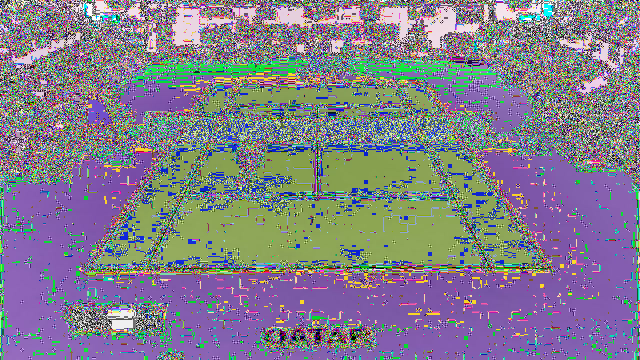

Ball is at position: 757, 186


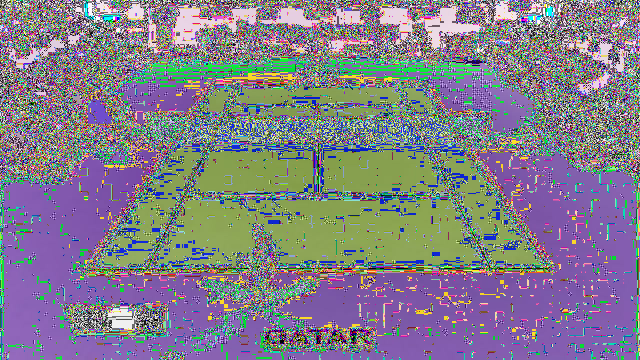

Ball is at position: 489, 405


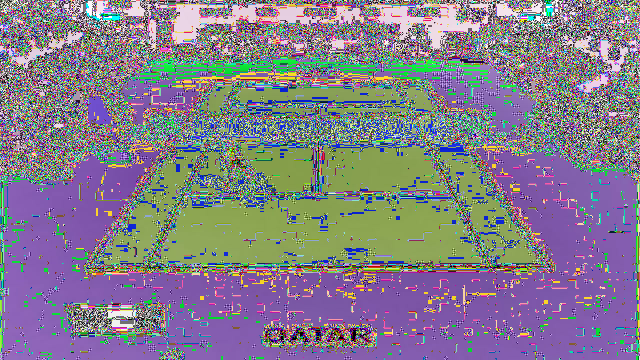

Ball is at position: 546, 139


In [34]:
imgs = dm.test_dataloader()

# display some images from the dataset
img_iterator = iter(imgs)
for i in range(3):
  img, label = next(img_iterator)
  show_img(img, label)


In [38]:
# train the model
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(project='TrackNetModelColab', job_type='train')
trainer = pl.Trainer(check_val_every_n_epoch=3, num_sanity_val_steps=1, accelerator="auto", max_epochs=5000,
                         #callbacks=[get_checkpoint_callback(), get_early_stopping(), ImagePredictionLogger()],
                         callbacks=[get_checkpoint_callback(), ImagePredictionLogger()],
                         logger=wandb_logger)
trainer.fit(model=classifier, datamodule=dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Data hasn't been read!!!
Number of train data:	1360
Number of validate data:	150
Number of test data:	378


wandb: Currently logged in as: filip-matysik (fm_2000). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type      | Params
--------------------------------------
0 | model   | TrackNet  | 15.7 M
1 | metrics | MyMetrics | 0     
--------------------------------------
15.7 M    Trainable params
0         Non-trainable params
15.7 M    Total params
62.882    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [39]:
trainer.test(model=classifier, datamodule=dm)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Data hasn't been read!!!
Number of train data:	1360
Number of validate data:	150
Number of test data:	378


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]